#Multiclass classification

-->it means to classify more than two catergories.

In [13]:
#creating the dataset

import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs #Generate isotropic Gaussian blobs for clustering.
from sklearn.model_selection import train_test_split


#set the hyperparameters for data creating
num_classes = 4
num_features = 2
random_seed = 42

#create multi-class data
x_blob , y_blob = make_blobs(n_samples = 1000,
                             n_features = num_features,
                             centers = num_classes,
                             cluster_std = 2.0, #makes more dense or light clusters
                             random_state = random_seed)


since we are using sklearn , it leveraged Numpy, so we have to convert the data into tensors.

In [45]:
x_blob = torch.from_numpy(x_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor) #we are doing longtensor for faster computation

#splitting the data into train and test
x_blob_train , x_blob_test , y_blob_train , y_blob_test = train_test_split(x_blob,
                                                                           y_blob,
                                                                           test_size=0.2,
                                                                           random_state = random_seed)



TypeError: expected np.ndarray (got Tensor)

In [ ]:
#plotting the data
plt.figure(figsize=(10,7))
plt.scatter(x_blob[:,0], x_blob[:,1], c=y_blob , cmap = plt.cm.RdYlBu)


we need a model, that can draw lines between these clusters.

In [47]:
#device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

#building the model


In [48]:
class BlobModel(nn.Module):
  def __init__(self, input_features , output_features , hidden_units = 8): #we are setting the default hidden_units as 8

    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features , out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units , out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units , out_features = output_features)
    )
  def forward(self,x_blob):
    return self.linear_layer_stack(x_blob)

model = BlobModel(input_features = 2 ,
                  output_features = 4,
                  hidden_units = 8).to(device)
model


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [49]:
x_blob_train.shape , y_blob_train[:5]

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]))

* for multiclass classification we will use Cross Entropy loss
* for binary classification we used BCELoss
* a loss function can also be referred to as **Criterion** or **Cost Function**.


In [51]:
#create a loss function and an optimizer

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = model.parameters(),
                            lr=0.1)

In [52]:
#getting prediction probabilities for a multi-class pytorch model

#getting the model on the same device

model.eval()
with torch.inference_mode():
  y_logits = model(x_blob_test.to(device))

y_logits[:10]



tensor([[-0.8118, -0.8307, -1.6751, -1.1760],
        [-0.0902, -0.9269, -0.5813, -0.1338],
        [ 0.2456, -0.2423,  0.1883, -0.0032],
        [-0.3472, -0.4911, -0.8196, -0.6231],
        [-0.3540, -1.4595, -1.3139, -0.4283],
        [-0.1611, -1.0871, -0.7362, -0.1712],
        [ 0.0953, -0.3387,  0.0747, -0.0551],
        [-0.2159, -1.1802, -0.9321, -0.2757],
        [ 0.2352, -0.2664,  0.1415,  0.0078],
        [-0.2434, -1.2318, -1.0178, -0.3158]])

these are the raw logits.

In [53]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

we need to convert these raw logits into prediction probabilities using a activation function.

# logits --> prediction probalities --> prediction labels

In [55]:
#converting these raw logits into prediction probabilities

y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.8118, -0.8307, -1.6751, -1.1760],
        [-0.0902, -0.9269, -0.5813, -0.1338],
        [ 0.2456, -0.2423,  0.1883, -0.0032],
        [-0.3472, -0.4911, -0.8196, -0.6231],
        [-0.3540, -1.4595, -1.3139, -0.4283]])
tensor([[0.3228, 0.3168, 0.1361, 0.2243],
        [0.3331, 0.1443, 0.2038, 0.3188],
        [0.2996, 0.1839, 0.2829, 0.2336],
        [0.3078, 0.2666, 0.1919, 0.2336],
        [0.3785, 0.1253, 0.1449, 0.3514]])


these are all pred probs, and all of them are +ves

In [57]:
print(torch.sum(y_pred_probs[0])) #they all sum up to 1
print(torch.max(y_pred_probs[0])) #this shows that the sum of the entire 0th row is 1 and the max probability is 0.2967
print(torch.argmax(y_pred_probs[0])) #index of max value

tensor(1.)
tensor(0.3228)
tensor(0)


In [58]:
#converting the pred probs to pred labels by taking the argmax of the pred probs

y_preds = torch.argmax(y_pred_probs , dim=1)
y_preds

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 3, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 3, 0, 0, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [59]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [60]:
#accuracy function
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

#creating a training and testing loop


In [61]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

#set number of epochs
epochs = 100

#putting the data to the target device
x_blob_train , y_blob_train = x_blob_train.to(device) , y_blob_train.to(device)
x_blob_test , y_blob_test = x_blob_test.to(device) , y_blob_test.to(device)

#loop through the data
for epoch in range(epochs):

  ##training
  model.eval()

  y_logits = model(x_blob_train)
  y_pred = torch.softmax(y_logits , dim=1).argmax(dim=1)

  loss = loss_fn(y_logits , y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train,
                    y_pred = y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  ##testing
  model.eval()
  with torch.inference_mode():
    test_logits = model(x_blob_test)
    test_pred = torch.softmax(test_logits , dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits , y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test,
                           y_pred = test_pred)

  if epoch % 10 == 0:
    print(f'epoch: {epoch} | loss: {loss:.4f} | acc: {acc:.2f}%  | test loss: {test_loss:.4f} | test acc: {test_acc:.2f}%')

epoch: 0 | loss: 1.1674 | acc: 40.50%  | test loss: 1.0856 | test acc: 50.00%
epoch: 10 | loss: 0.6813 | acc: 92.88%  | test loss: 0.6943 | test acc: 92.00%
epoch: 20 | loss: 0.4782 | acc: 94.62%  | test loss: 0.4837 | test acc: 95.50%
epoch: 30 | loss: 0.3216 | acc: 95.88%  | test loss: 0.3134 | test acc: 97.00%
epoch: 40 | loss: 0.1830 | acc: 96.12%  | test loss: 0.1693 | test acc: 96.50%
epoch: 50 | loss: 0.1316 | acc: 96.25%  | test loss: 0.1194 | test acc: 96.50%
epoch: 60 | loss: 0.1150 | acc: 96.25%  | test loss: 0.1025 | test acc: 96.50%
epoch: 70 | loss: 0.1073 | acc: 96.12%  | test loss: 0.0946 | test acc: 96.50%
epoch: 80 | loss: 0.1030 | acc: 96.12%  | test loss: 0.0901 | test acc: 96.50%
epoch: 90 | loss: 0.1002 | acc: 96.12%  | test loss: 0.0873 | test acc: 96.50%


In [62]:
#decision boundary function

import numpy as np
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Setup prediction boundaries and grid
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)  # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))  # binary


    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


In [63]:
model.eval()
with torch.inference_mode():

  y_logits = model(x_blob_test)

y_logits[:10]

tensor([[  0.0115,   6.0601,  -8.4093,  -8.4163],
        [ -1.4769,  -6.0067,  -4.1702,   2.5993],
        [ -3.3982,  -3.7515,   3.1081,  -2.6314],
        [ -1.0987,   4.1476,  -3.5406,  -4.2915],
        [  3.7035,  -1.0898, -10.0379,  -6.3261],
        [ -2.0053,  -7.4626,  -5.2498,   3.4261],
        [ -2.9233,  -3.0336,   2.7233,  -2.0891],
        [  2.8830,  -4.4700,  -7.1183,  -2.5822],
        [ -4.5562,  -5.1398,   3.8900,  -3.6046],
        [  3.3123,  -3.2114,  -7.8873,  -3.7766]])

In [65]:
#logits --> pred probs

y_pred_probs = torch.softmax(y_logits , dim=1)
y_pred_probs[:10]

tensor([[2.3556e-03, 9.9764e-01, 5.1879e-07, 5.1516e-07],
        [1.6666e-02, 1.7971e-04, 1.1276e-03, 9.8203e-01],
        [1.4854e-03, 1.0433e-03, 9.9427e-01, 3.1980e-03],
        [5.2357e-03, 9.9409e-01, 4.5550e-04, 2.1496e-04],
        [9.9174e-01, 8.2164e-03, 1.0680e-06, 4.3712e-05],
        [4.3570e-03, 1.8583e-05, 1.6986e-04, 9.9545e-01],
        [3.4778e-03, 3.1147e-03, 9.8540e-01, 8.0098e-03],
        [9.9511e-01, 6.3754e-04, 4.5122e-05, 4.2110e-03],
        [2.1453e-04, 1.1968e-04, 9.9911e-01, 5.5558e-04],
        [9.9769e-01, 1.4649e-03, 1.3647e-05, 8.3236e-04]])

In [66]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [67]:
#pred probs --> pred labels

y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

#Plotting the decision boundary between the clusters

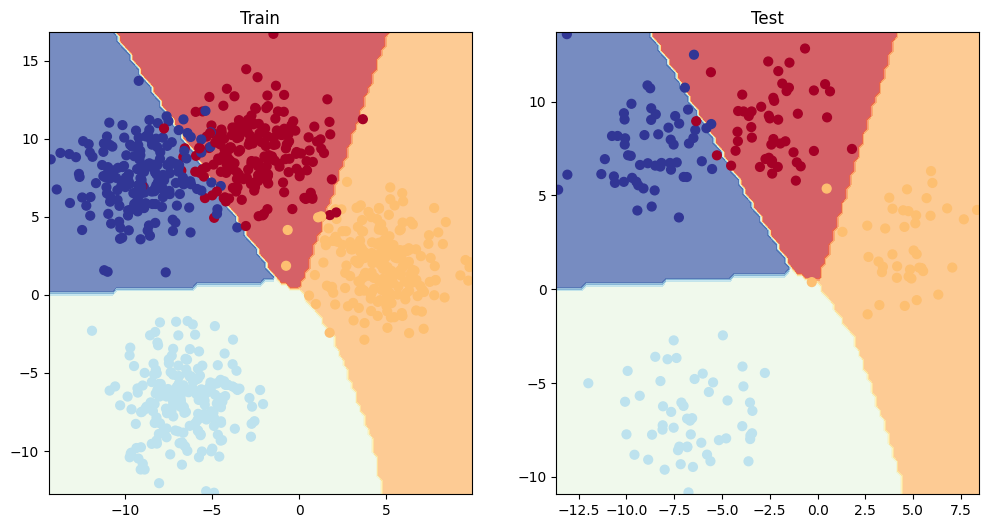

In [68]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model, x_blob_train , y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model, x_blob_test , y_blob_test)

#can we separate this data without Non-Linear Function?

--> We can, because these lines are more of straight lines and we can actually draw straight lines to separate our clusters.


# a few more classification metrics to evaluate the model.


1. accuracy --> out of 100 samples , how many our model gets right
2. precision --> high precision leads to less false positives
3. recall --> high precision leads to lesser false negatives
4. F1 Score --> combination of precision and recall
5. Confusion matrix --> table describing the performance of the model.
6. classification report --> sums up all the metrics
